# Introduction


## Context
A startup that sells software would like to know whether its multiple outreach efforts were successful in attracting new customers or boosting consumption among existing customers. They would also like to distinguish the effects of several incentives on different kinds of customers. In other words, they would like to learn the heterogeneous treatment effect of each investment on customers' software usage.

In an ideal world, the startup would run several randomized experiments where each customer would receive a random assortment of investments. However, this can be logistically prohibitive or strategically unsound: the startup might not have the resources to design such experiments or they might not want to risk losing out on big opportunities due to lack of incentives.

## Content
The data* contains ~2,000 customers and is comprised of:

Customer features: details about the industry, size, revenue, and technology profile of each customer.<br>
Interventions: information about which incentive was given to a customer.<br>
Outcome: the amount of product the customer bought in the year after the incentives were given.<br>

# Solution Planning

## IOT (Input, Output, Tasks)

### Inputs
- Data from customers and interventions (incentives given)

### Outputs
- Presentation with the results of the campaing, bringing the isolate effect of each incentive on the consumption of the clients

### Tasks
1. Get the data
    (In this case we have the .csv file, but this step could involve writting a query to get the data from a data warehouse)
2. Do an exploratory analysis to get acquainted with the features
3. Apply Causal Inference techniques
4. Make a presentation with the results

# Code

## 0.0 Imports

In [31]:
import pandas as pd
import numpy as np 
import re

import sweetviz as sv
import seaborn as sns

from IPython.core.display  import HTML
from IPython.display       import Image

from dython.nominal import associations

from causallearn.search.ConstraintBased.PC import pc

from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from causallearn.search.ScoreBased.GES import ges
import io


### 0.1 Data

In [2]:
data_raw = pd.read_csv('../data/multi_attribution_sample.csv')

In [3]:
data_raw.head()

,Global Flag,Major Flag,SMC Flag,Commercial Flag,IT Spend,Employee Count,PC Count,Size,Tech Support,Discount,Revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.36300
1,0,0,1,1,20842,107,70,159038,0,1,14981.43559
2,0,0,0,1,82171,10,7,264935,1,1,32917.13894
3,0,0,0,0,30288,40,39,77522,1,1,14773.76855
4,0,0,1,0,25930,37,43,91446,1,1,17098.69823


### 0.2 Auxiliar functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = 100
    pd.options.display.max_rows = 100
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
jupyter_settings()


pd.set_option('display.float_format', lambda x: '%.3f' % x)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 1.0 Descriptive analysis

In [5]:
data_description = data_raw.copy()

### 1.1 Renaming columns (to snake case)

In [6]:
new_columns = [i.lower().replace(' ', '_') for i in data_description.columns]
data_description.columns = new_columns
    

In [7]:
data_description.head()

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.363
1,0,0,1,1,20842,107,70,159038,0,1,14981.436
2,0,0,0,1,82171,10,7,264935,1,1,32917.139
3,0,0,0,0,30288,40,39,77522,1,1,14773.769
4,0,0,1,0,25930,37,43,91446,1,1,17098.698


### 1.2 Check data dimension

In [8]:
print('Number of rows: {} \nNumber of columns: {}'.format(data_description.shape[0],data_description.shape[1]))

Number of rows: 2000 
Number of columns: 11


### 1.3 Quick descriptive analysis

|       name      | type |                                                  description                                                  |
|:---------------:|:----:|:-------------------------------------------------------------------------------------------------------------:|
| Global Flag     | W    | whether the customer has global offices                                                                       |
| Major Flag      | W    | whether the customer is a large consumer in their industry (as opposed to SMC - Small Medium Corporation - or |
| SMC Flag        | W    | whether the customer is a Small Medium Corporation (SMC, as opposed to major and SMB)                         |
| Commercial Flag | W    | whether the customer's business is commercial (as opposed to public secor)                                    |
| IT Spend        | W    | $ spent on IT-related purchases                                                                               |
| Employee Count  | W    | number of employees                                                                                           |
| PC Count        | W    | number of PCs used by the customer                                                                            |
| Size            | X    | customer's size given by their yearly total revenue                                                           |
| Tech Support    | T    | whether the customer received tech support (binary)                                                           |
| Discount        | T    | whether the customer was given a discount (binary)                                                            |
| Revenue         | Y    | $ Revenue from customer given by the amount of software purchased                                             |

                                             |          | [  0%]   00:00 -> (? left)


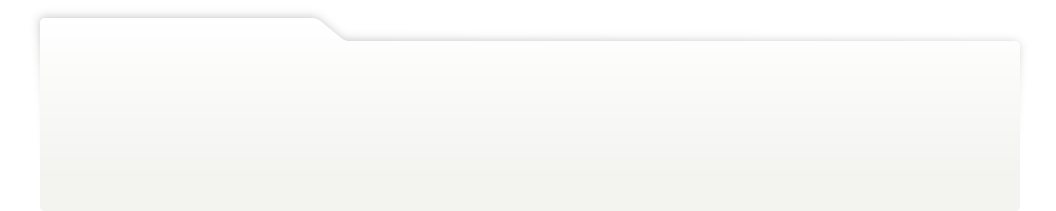
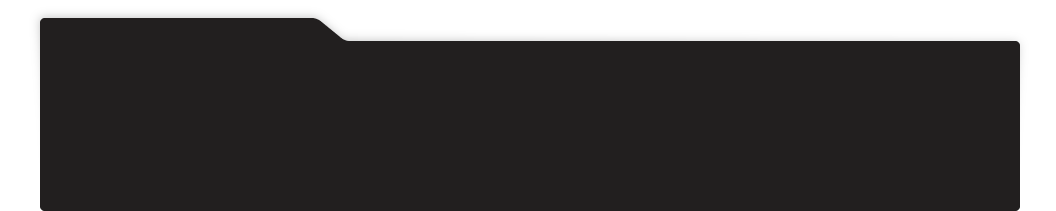
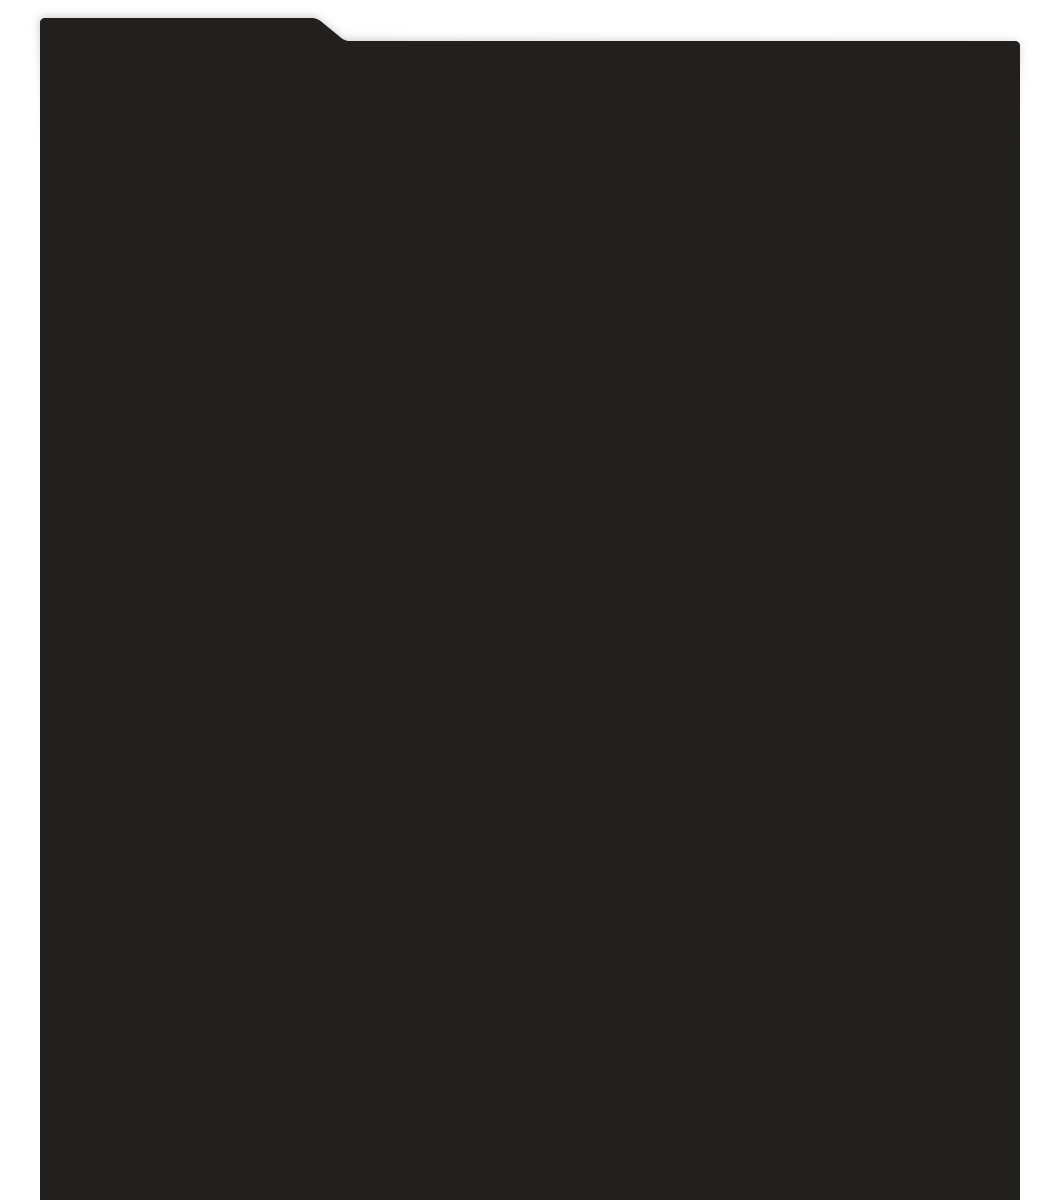
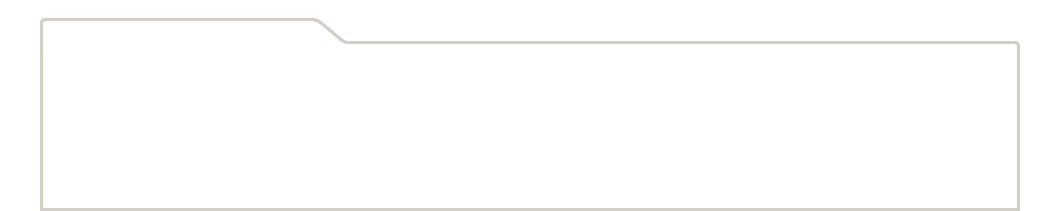
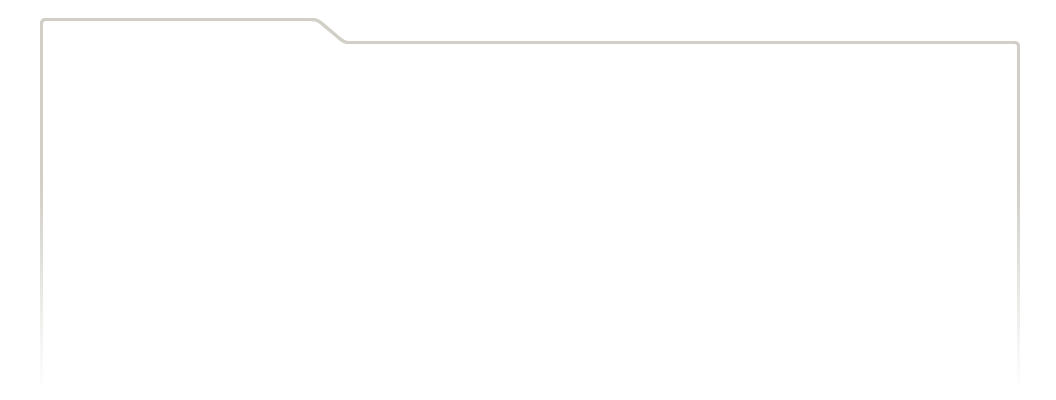
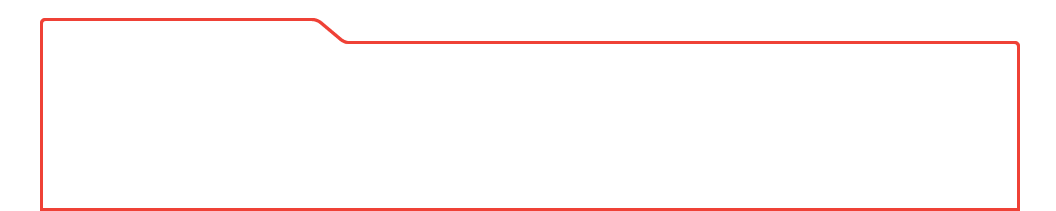
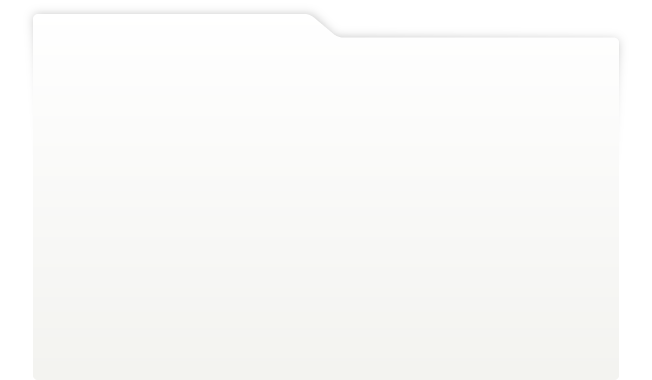
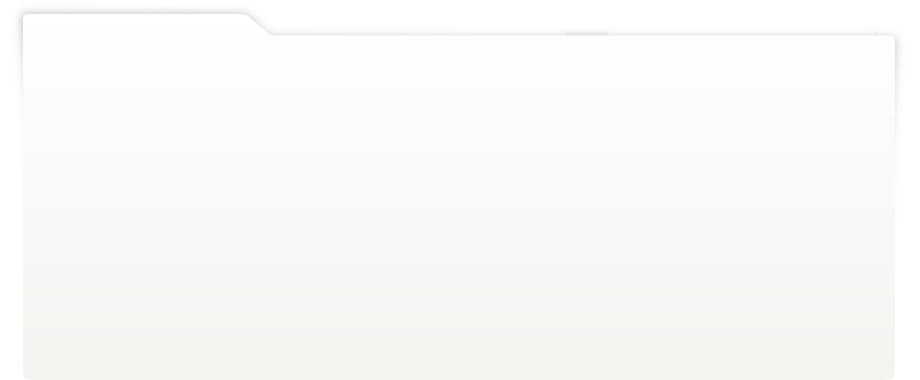
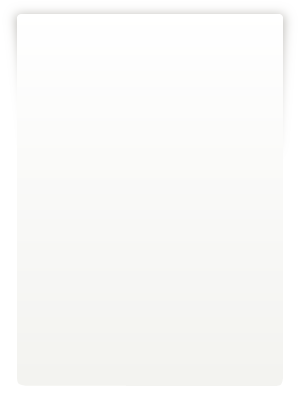
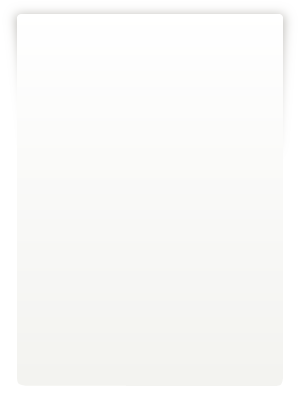
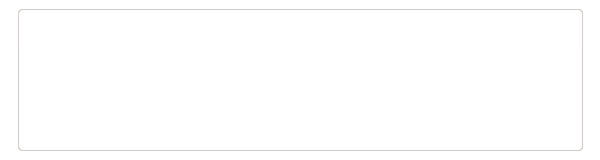
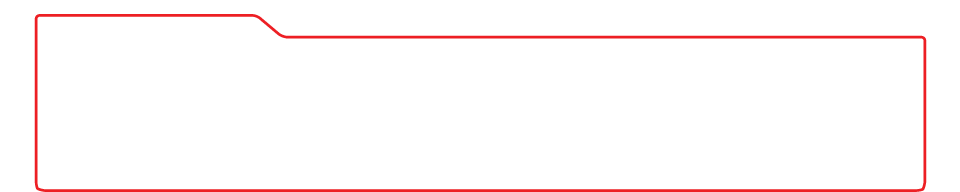
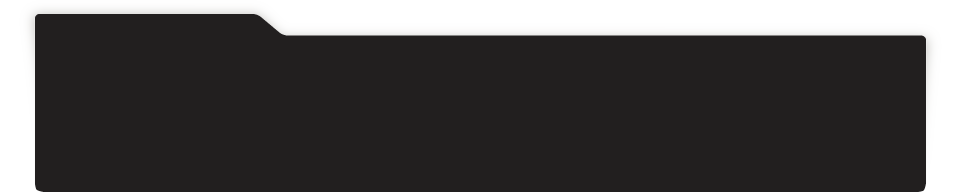
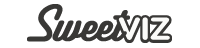
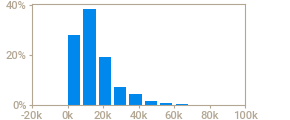
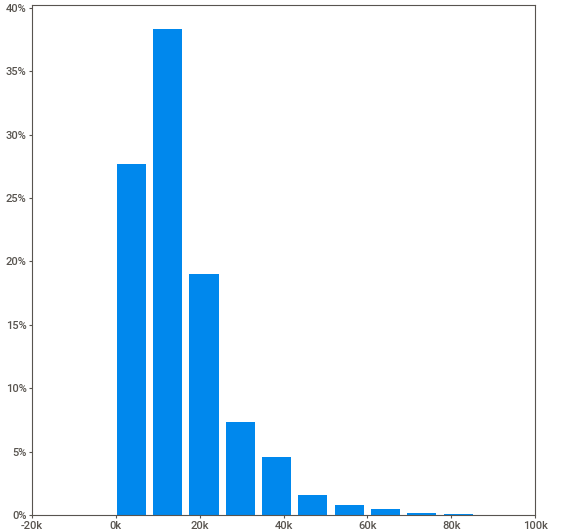
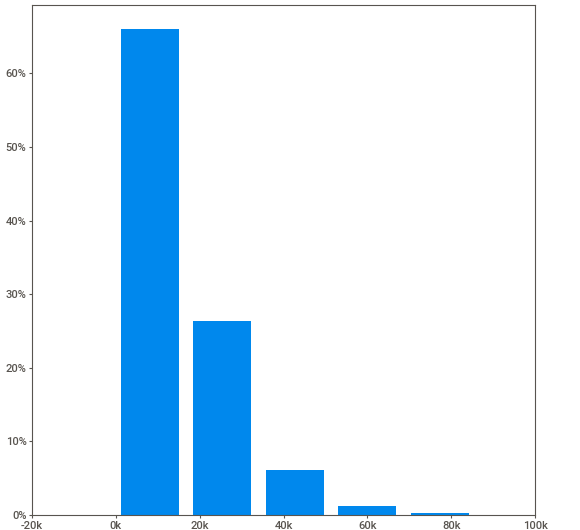
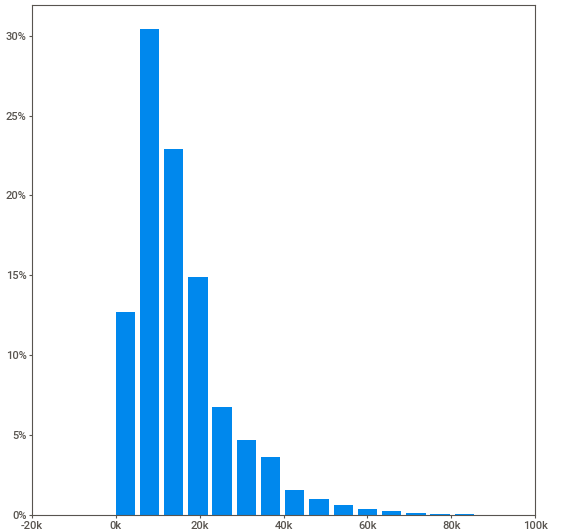
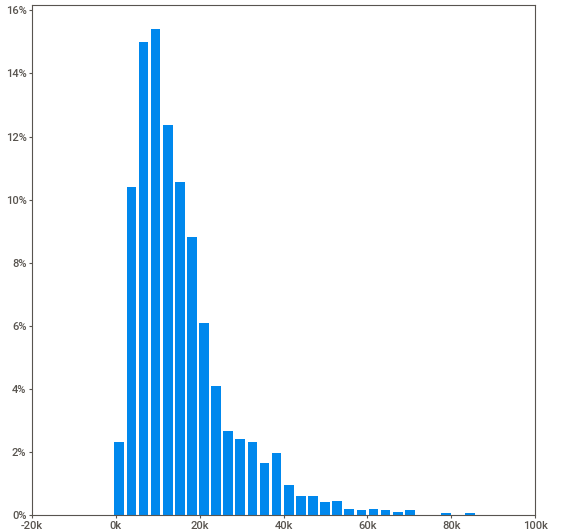
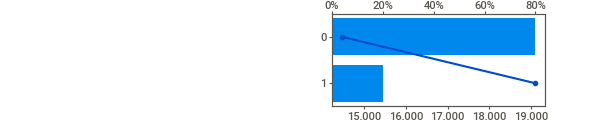
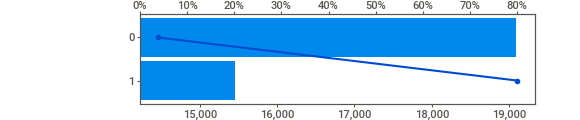
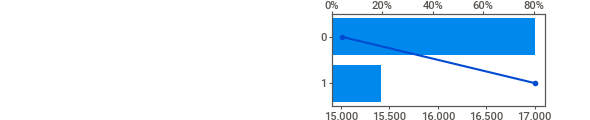
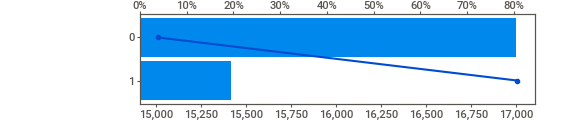
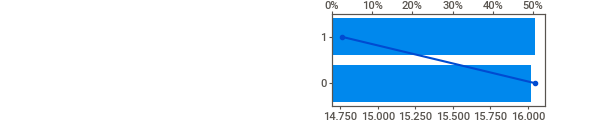
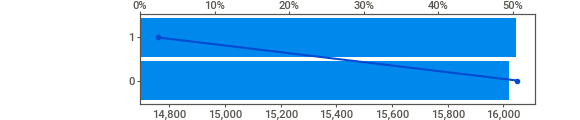
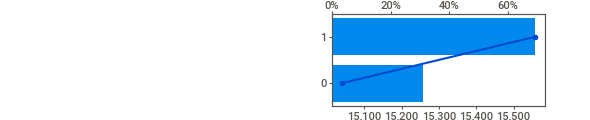
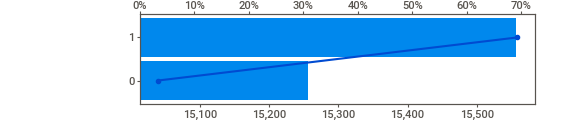
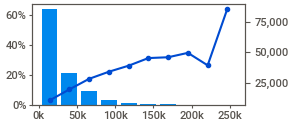
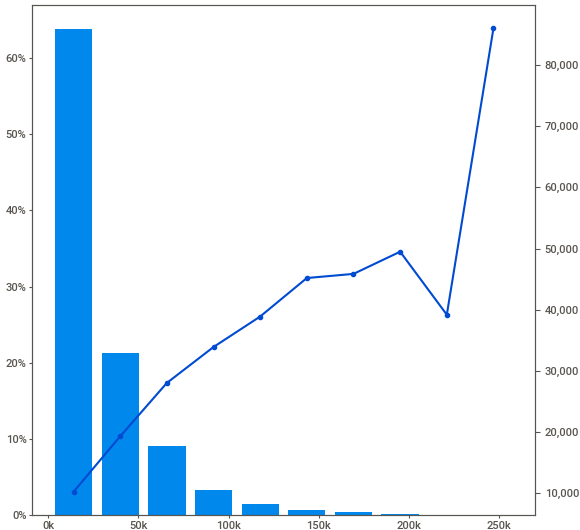
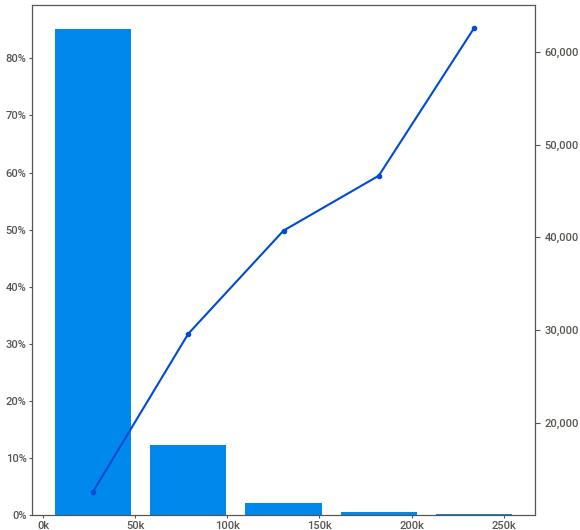
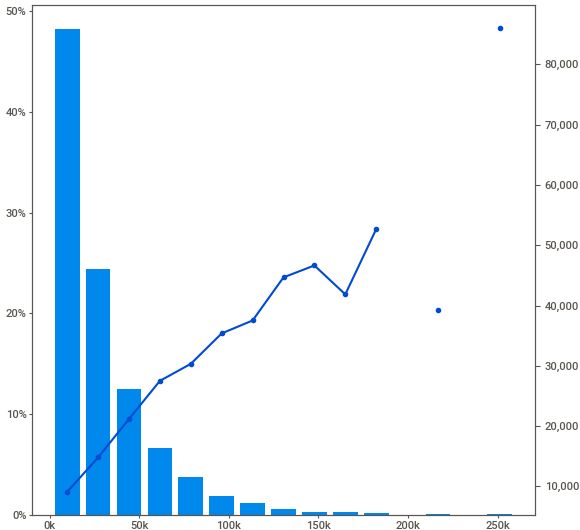
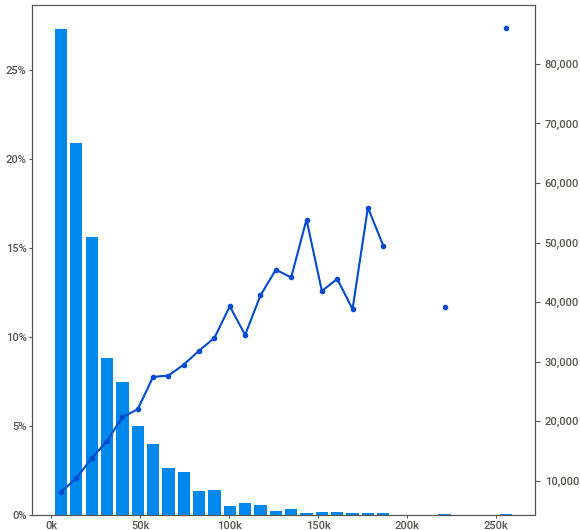
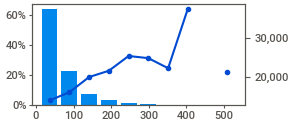
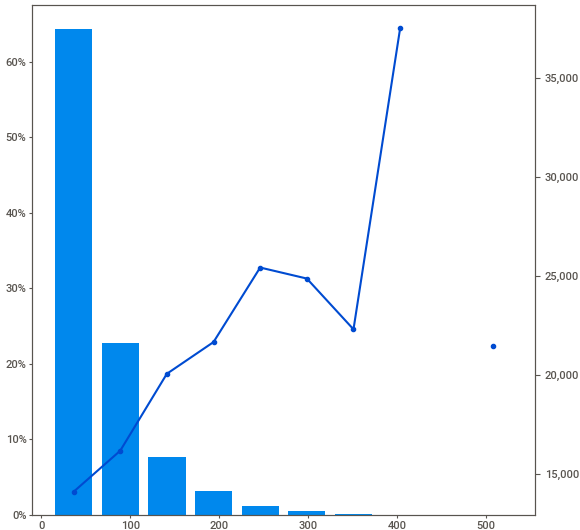
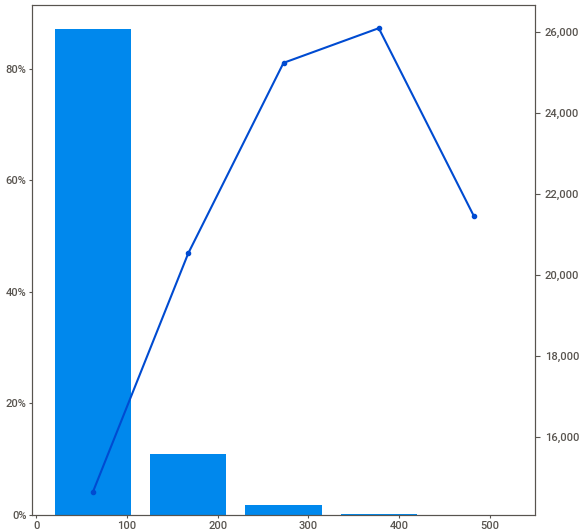
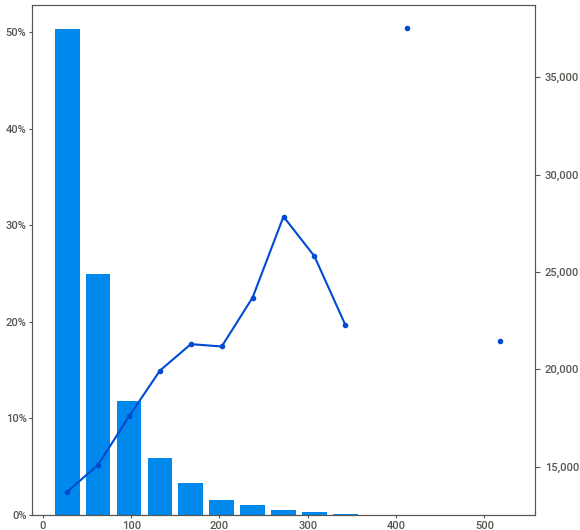
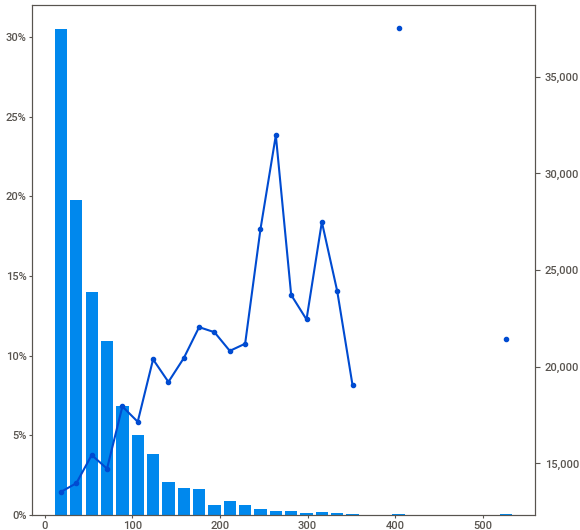
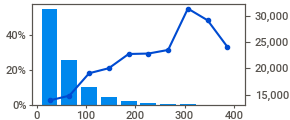
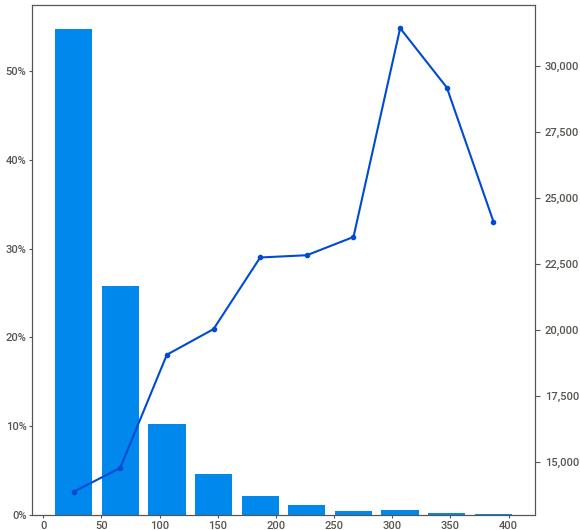
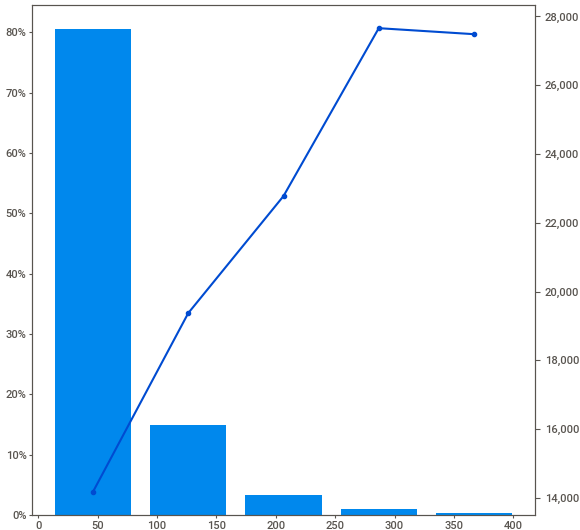
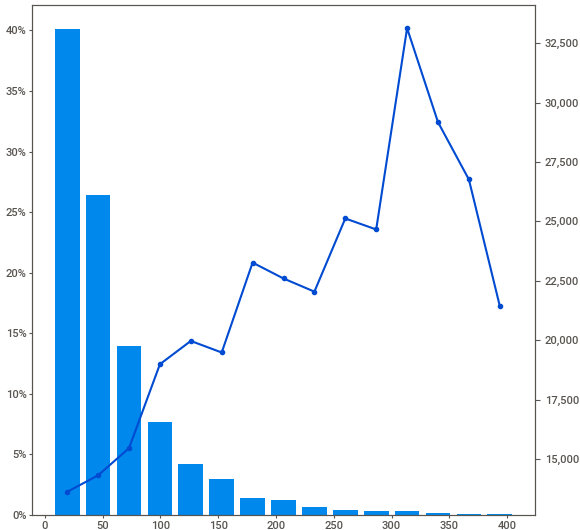
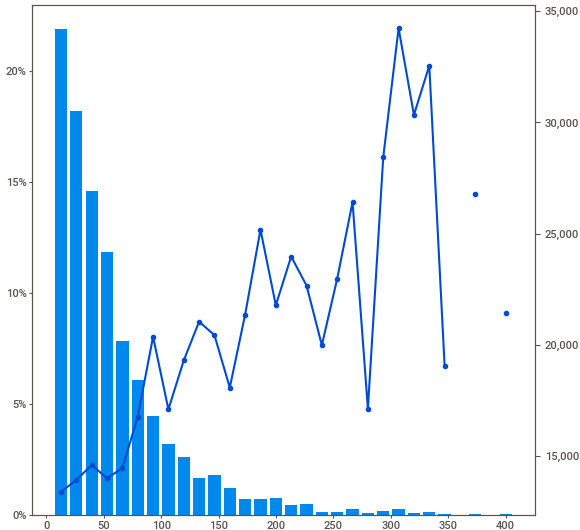
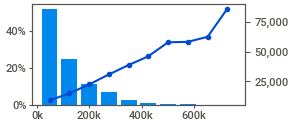
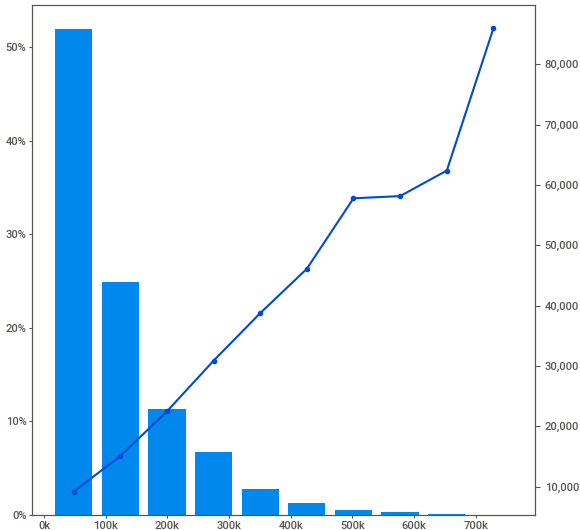
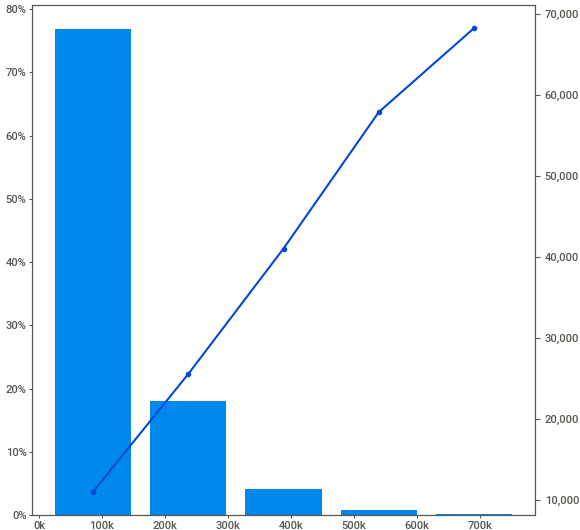
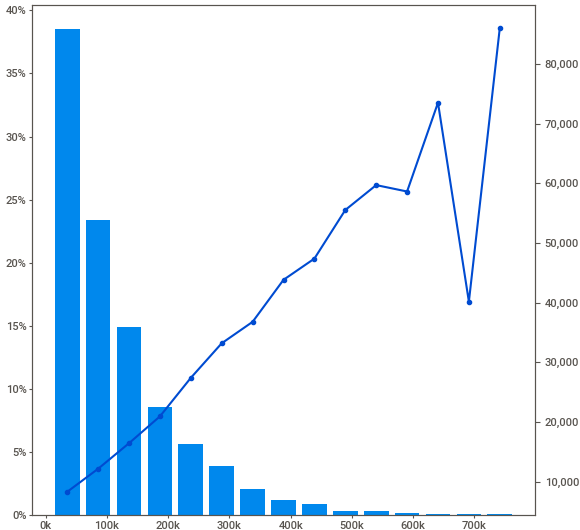
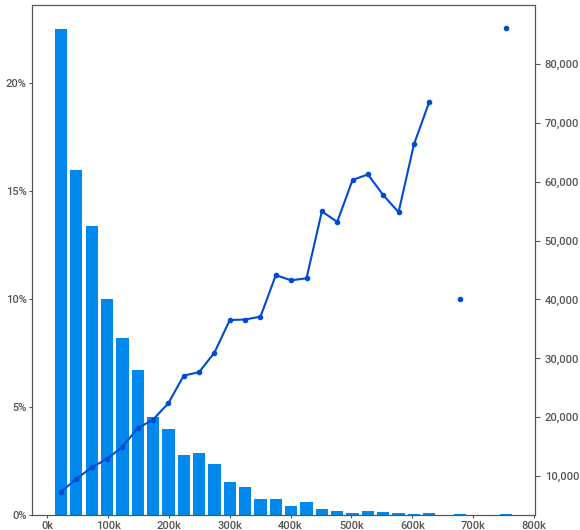
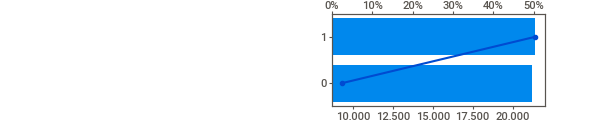
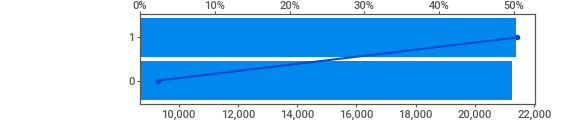
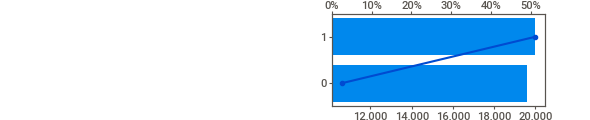
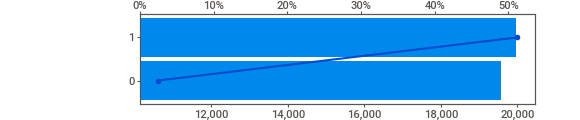
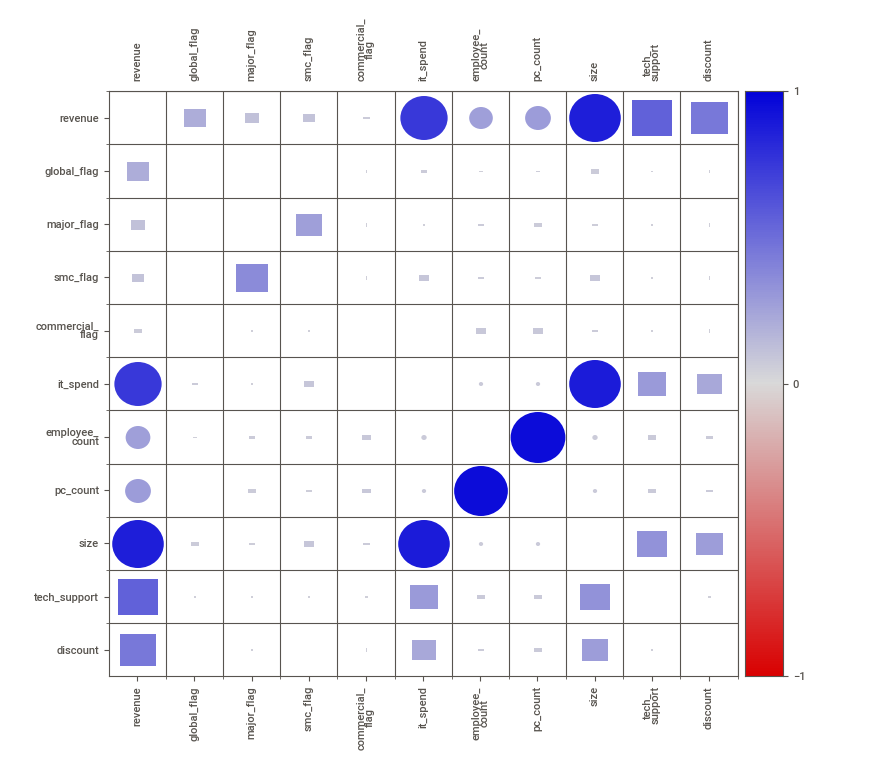
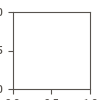

In [9]:
descriptive_analysis_report_001 = sv.analyze(data_description, target_feat='revenue')
descriptive_analysis_report_001.show_notebook()

#### Observations and comments: 
- Associations are given by: 
    - Pearson (numerical-numerical)
        - It measures the linear association between two continuous variables. 
        - Assumes that both distributions are normal and that there is no outliers <br>
    **None of our continuous variables have normal distribution, so Pearsons Correlation may not be the best way to identify this relationships**
    <br>
    <br>
    
    - Uncertainty coefficient (caegorical-categorical)
        - It measures the association that takes into account the uncertainty or randomness of the variables. <br>
    It's possible to get the association by other methods, like Cramer-V, which uses chi-squared test and a contingency table

    - Correlation ratio (categorical-numerical)
        - It measures the degree to which the numerical variable varies across the categories of the categorical variable

<br>
<br> 


- Some assumptions that could make sense: 
    - The number of pc and employees should be highly correlated
    - The larger the company, the greater the expenses with IT
    - The higher spending on IT, the greater chance of increasing revenue
- There are a few things to check:
    - If a company is not Major and is not SMC, it is SMB (accordingly to the metadata description given by the data's owner) -> But what is a SMB?

In [10]:
data_description.columns

Index(['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'it_spend',
       'employee_count', 'pc_count', 'size', 'tech_support', 'discount',
       'revenue'],
      dtype='object')

In [11]:
nominal_columns=['global_flag', 'major_flag', 'smc_flag', 'commercial_flag', 'tech_support', 'discount']
numerical_columns= ['it_spend','employee_count', 'pc_count', 'size', 'revenue']

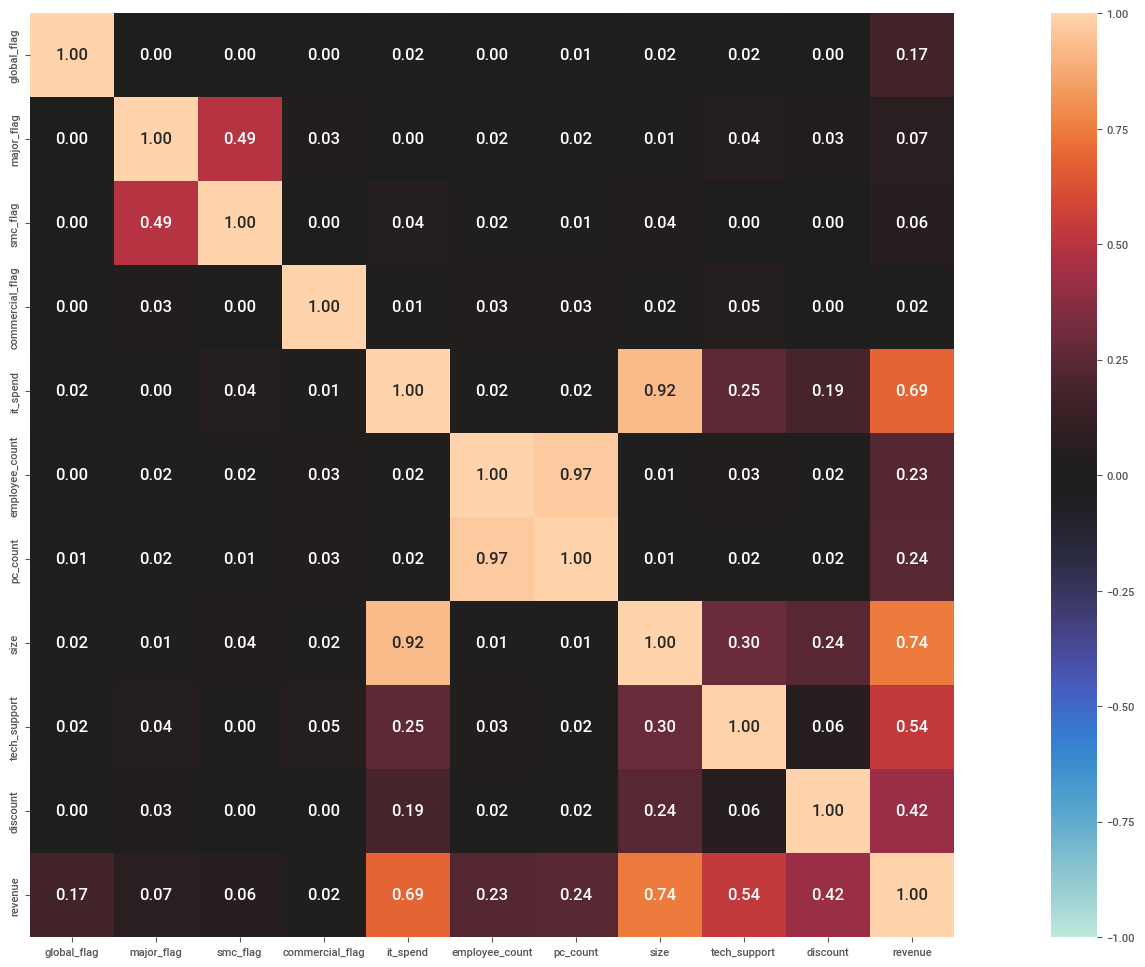

{'corr':                  global_flag  major_flag  smc_flag  commercial_flag  it_spend  employee_count  pc_count  size  tech_support  discount  revenue
 global_flag            1.000       0.000     0.000            0.000     0.018           0.005     0.008 0.020         0.017     0.000    0.165
 major_flag             0.000       1.000     0.495            0.028     0.003           0.016     0.021 0.012         0.041     0.026    0.070
 smc_flag               0.000       0.495     1.000            0.000     0.043           0.016     0.013 0.038         0.000     0.000    0.057
 commercial_flag        0.000       0.028     0.000            1.000     0.009           0.033     0.033 0.018         0.046     0.000    0.021
 it_spend               0.018       0.003     0.043            0.009     1.000           0.016     0.020 0.925         0.254     0.186    0.686
 employee_count         0.005       0.016     0.016            0.033     0.016           1.000     0.965 0.009         0.028    

In [12]:
associations(data_description, nominal_columns=nominal_columns, 
            numerical_columns=numerical_columns, nom_nom_assoc='cramer', num_num_assoc='spearman', nom_num_assoc='correlation_ratio')

### 1.4 Data Cleaning

#### 1.4.1 Major x SMC

In [13]:
data_description.loc[(data_description['major_flag']==1) & (data_description['smc_flag']==1)]

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue


In [14]:
# SMB - what does it mean?? 
data_description.loc[(data_description['major_flag']==0) & (data_description['smc_flag']==0)]

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue
2,0,0,0,1,82171,10,7,264935,1,1,32917.139
3,0,0,0,0,30288,40,39,77522,1,1,14773.769
6,1,0,0,0,40199,21,14,126342,0,0,9153.974
8,0,0,0,1,23428,50,55,77298,1,1,17265.111
10,0,0,0,1,151143,84,58,417289,1,1,50875.560
...,...,...,...,...,...,...,...,...,...,...,...
1987,1,0,0,1,14772,63,74,54855,0,0,8930.495
1988,0,0,0,1,3504,321,334,15802,1,0,21081.756
1989,0,0,0,1,25058,161,139,127963,1,0,18045.751
1993,0,0,0,1,17504,28,30,124231,1,0,13802.466


In [15]:
data_description.loc[(data_description['major_flag']==1) & (data_description['smc_flag']==0)]

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue
31,1,1,0,0,35303,108,136,120173,0,1,20237.792
38,1,1,0,0,45422,45,56,193432,0,0,15182.775
41,0,1,0,1,20901,85,80,115902,1,0,15864.392
43,0,1,0,0,25002,34,22,99114,1,0,13303.015
49,0,1,0,1,32794,76,47,101073,0,0,8797.225
...,...,...,...,...,...,...,...,...,...,...,...
1967,0,1,0,1,13139,14,16,73949,0,1,10114.246
1973,0,1,0,1,38481,30,34,104335,1,0,15149.978
1991,0,1,0,1,20893,70,47,112880,1,0,15249.063
1997,0,1,0,0,4195,14,17,11924,0,0,2161.746


In [16]:
data_description.loc[(data_description['major_flag']==0) & (data_description['smc_flag']==1)]

,global_flag,major_flag,smc_flag,commercial_flag,it_spend,employee_count,pc_count,size,tech_support,discount,revenue
0,1,0,1,0,45537,26,26,152205,0,1,17688.363
1,0,0,1,1,20842,107,70,159038,0,1,14981.436
4,0,0,1,0,25930,37,43,91446,1,1,17098.698
5,0,0,1,0,34597,44,51,218703,1,0,17280.709
7,0,0,1,1,30454,11,8,96784,0,0,5760.075
...,...,...,...,...,...,...,...,...,...,...,...
1990,1,0,1,1,105538,97,117,267677,0,1,32454.818
1992,0,0,1,1,4716,27,32,18150,0,0,4607.795
1994,1,0,1,1,22440,33,29,99953,1,0,17706.840
1995,0,0,1,1,46186,74,48,141579,0,1,13930.129


## 2.0 Causal Inference

### 2.1 Causal discovery

This step is to find out the causal relationship between our features an draw a DAG, which will be used on the next steps. For this step, I will use the Causal Learn Library with the PC algorithm. This algorithm is based on Conditional Independence Test

In [17]:
data_numpy = data_description.to_numpy()

  0%|          | 0/11 [00:00<?, ?it/s]

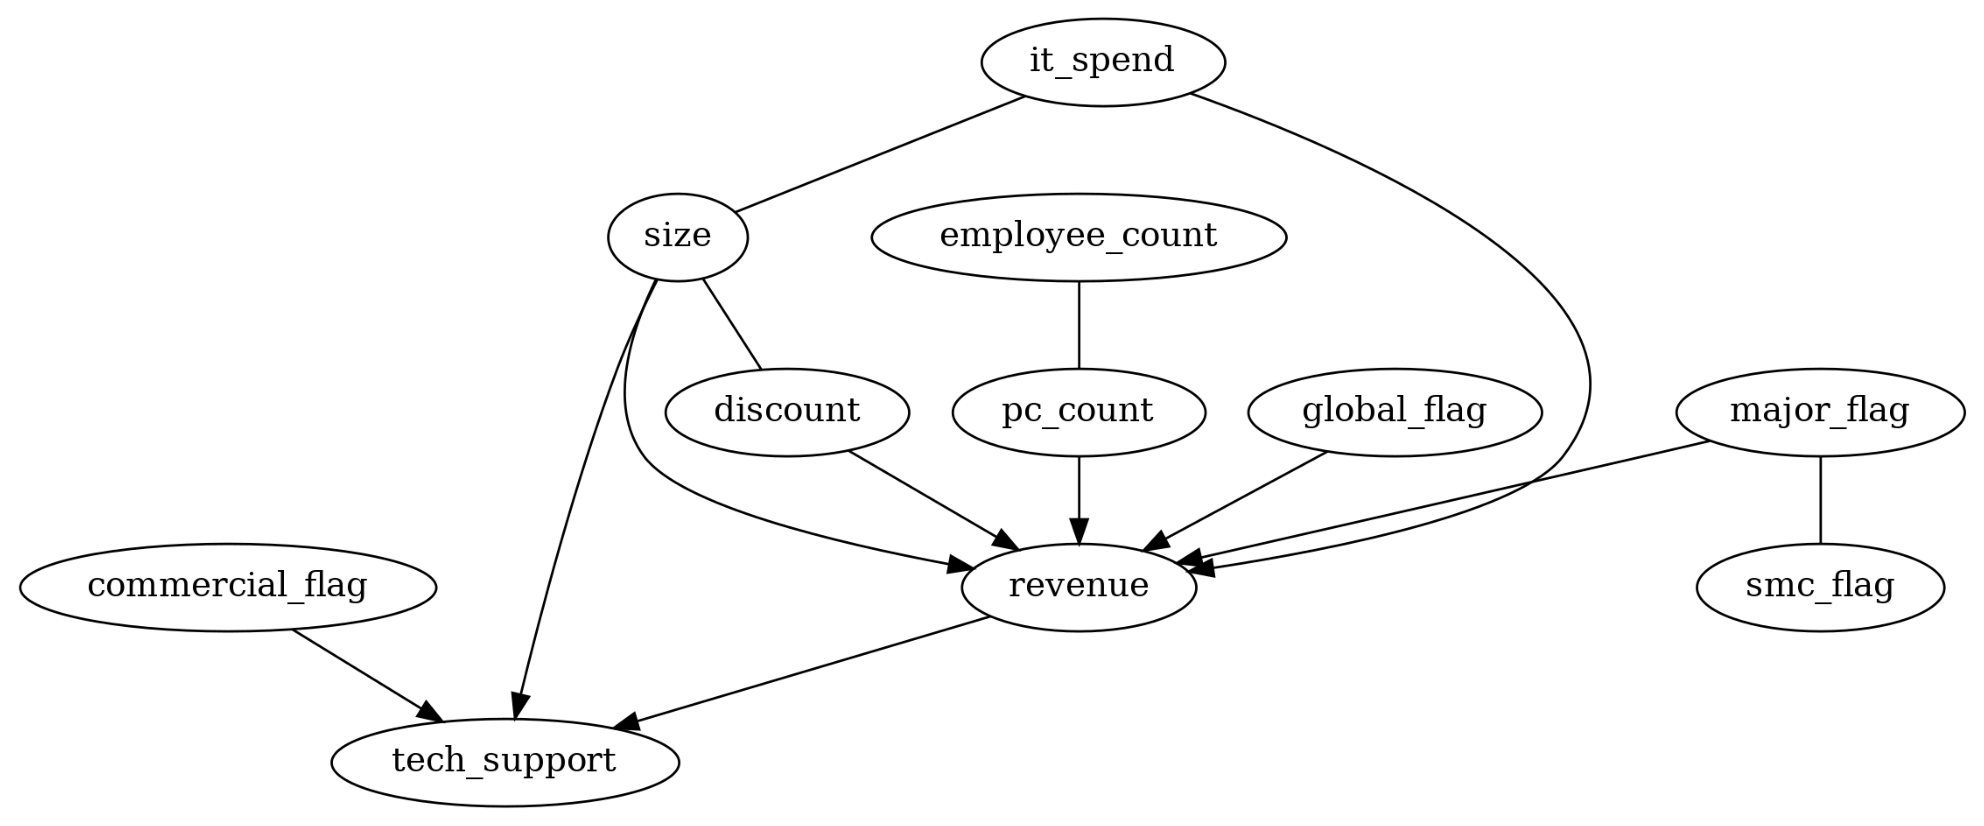

In [19]:
cg = pc(data_numpy)
cg.draw_pydot_graph(labels=data_description.columns)

  0%|          | 0/11 [00:00<?, ?it/s]

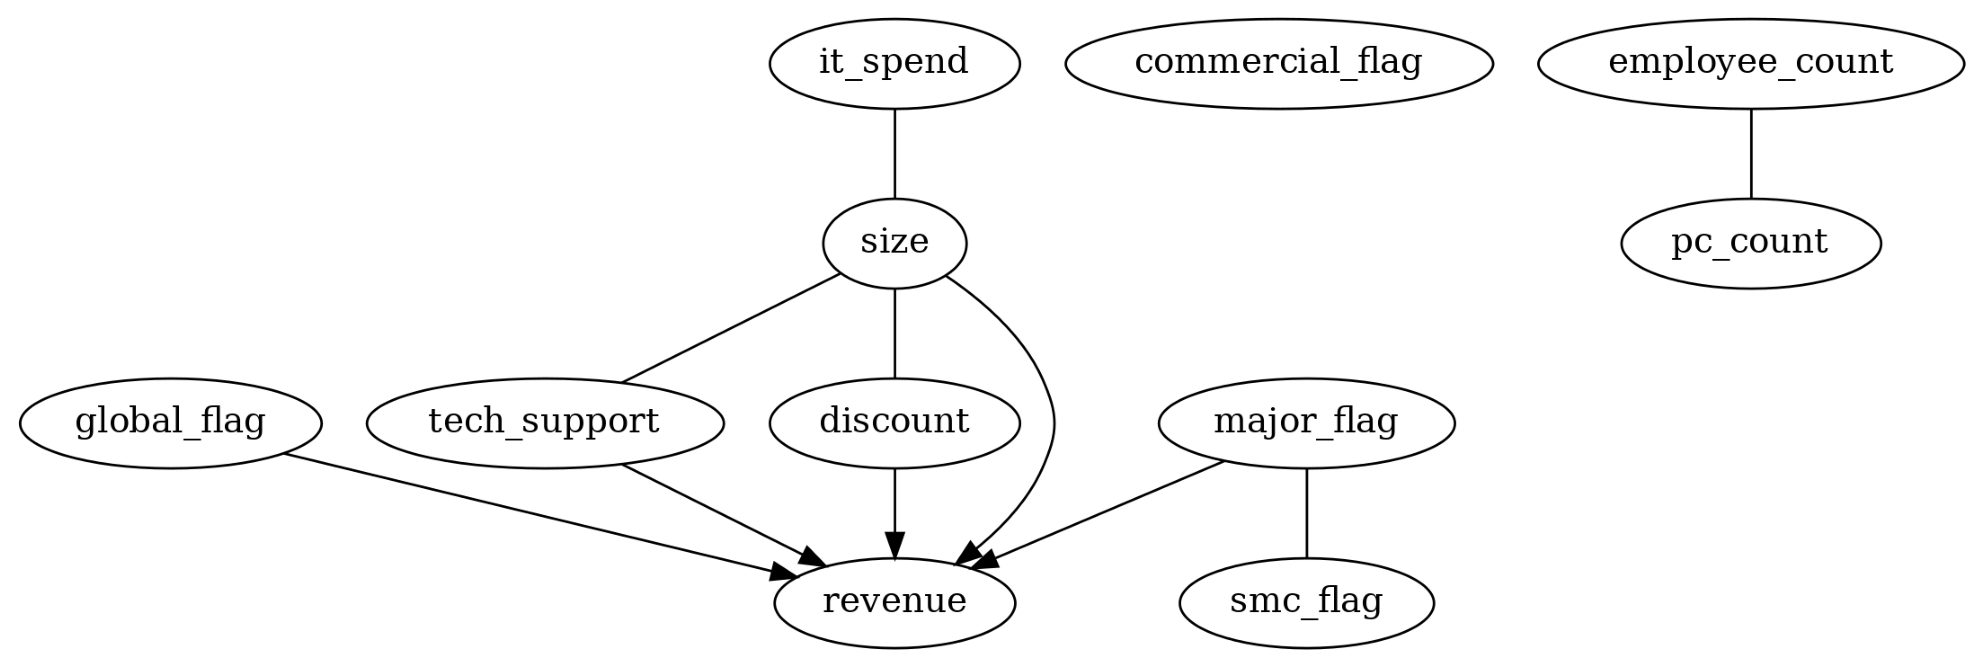

In [23]:
cg = pc(data_numpy,  indep_test = 'kci')
cg.draw_pydot_graph(labels=data_description.columns)

In [26]:
Record = ges(data_numpy)

[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]]
[[ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0 -1  0 

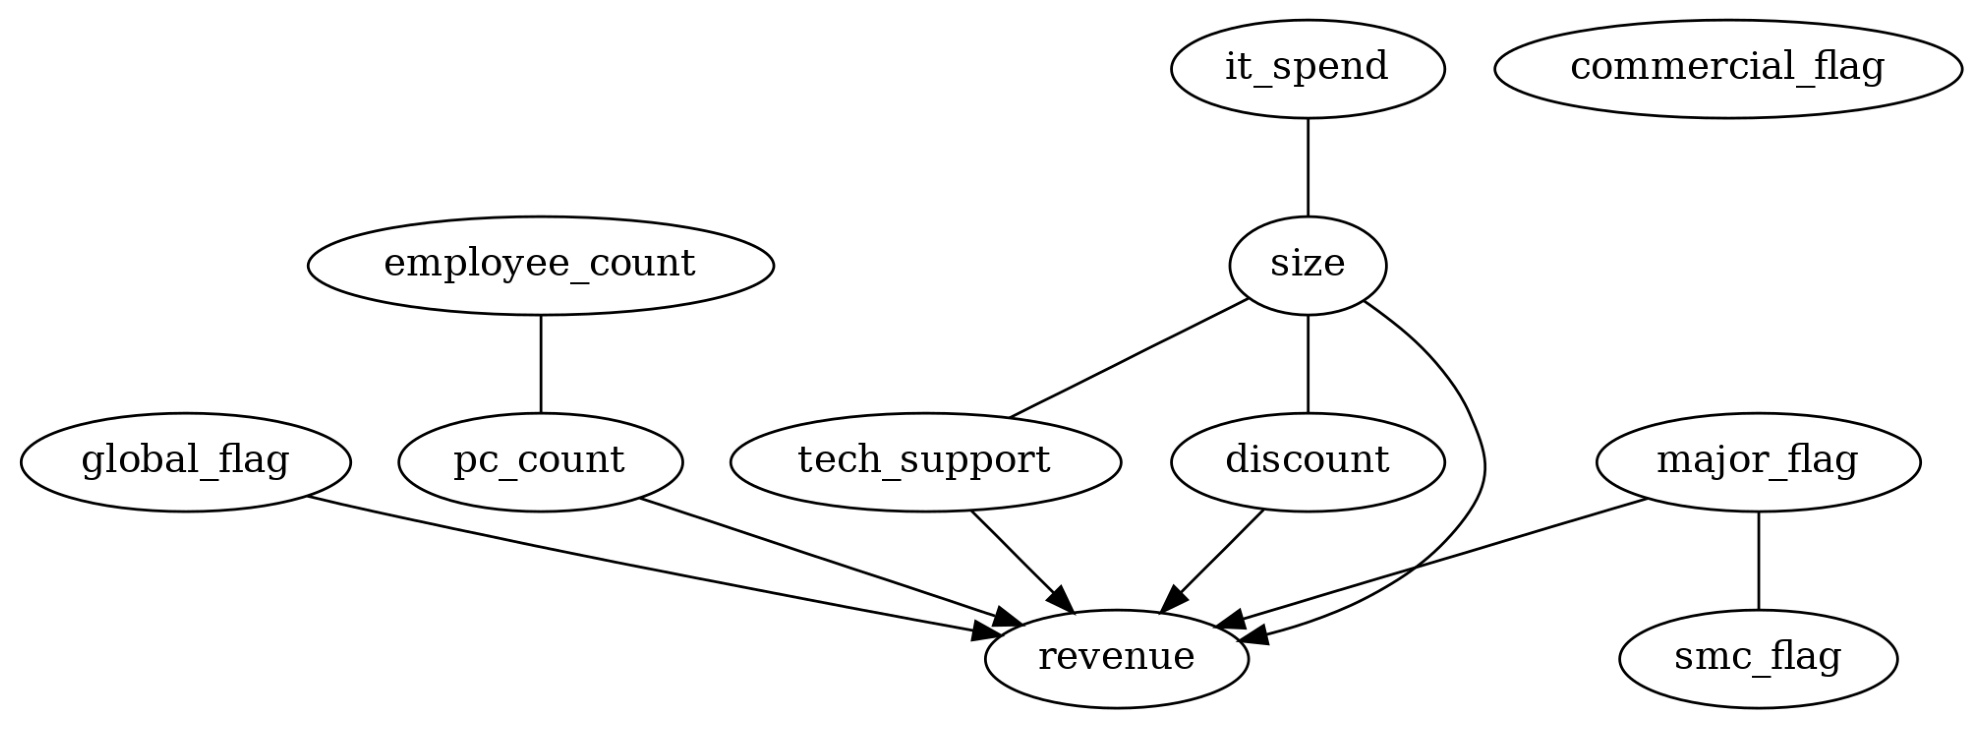

In [29]:


pyd = GraphUtils.to_pydot(Record['G'], labels=data_description.columns)
tmp_png = pyd.create_png(f="png")
fp = io.BytesIO(tmp_png)
img = mpimg.imread(fp, format='png')
plt.axis('off')
plt.imshow(img)
plt.show()

tech_support -> revenue <br>
tech_support <- size -> revenue <br>
tech_support <- size -> discount -> revenue <br>